# Classification with Naive Bayes

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
iris_df = sns.load_dataset('iris')

In [3]:
# dataset vars:
# ,
feature_vars = ['petal_width', 'sepal_length', 'sepal_width','petal_length']
target_var = 'species'
X_train, X_test, y_train, y_test = train_test_split(iris_df[feature_vars],iris_df[target_var],random_state=0)

In [4]:
X_train.head()

,petal_width,sepal_length,sepal_width,petal_length
61,1.5,5.9,3.0,4.2
92,1.2,5.8,2.6,4.0
112,2.1,6.8,3.0,5.5
2,0.2,4.7,3.2,1.3
141,2.3,6.9,3.1,5.1


In [5]:
iris_df.head(1)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa


In [6]:
X_train.shape, iris_df.shape

((112, 4), (150, 5))

In [7]:
112/150

0.7466666666666667

In [8]:
gnb = GaussianNB()

In [9]:
gnb.__dict__

{'priors': None, 'var_smoothing': 1e-09}

In [10]:
gnb.fit(X_train,y_train)

GaussianNB()

In [11]:
gnb.__dict__

{'priors': None,
 'var_smoothing': 1e-09,
 'classes_': array(['setosa', 'versicolor', 'virginica'], dtype='<U10'),
 'feature_names_in_': array(['petal_width', 'sepal_length', 'sepal_width', 'petal_length'],
       dtype=object),
 'n_features_in_': 4,
 'epsilon_': 3.2135586734693885e-09,
 'theta_': array([[0.24054054, 4.9972973 , 3.38918919, 1.45405405],
        [1.30882353, 5.91764706, 2.75882353, 4.19117647],
        [2.03902439, 6.66341463, 2.9902439 , 5.58292683]]),
 'var_': array([[0.01159971, 0.12242513, 0.14474799, 0.01978087],
        [0.0408045 , 0.2649827 , 0.11124568, 0.22139274],
        [0.06579417, 0.4071981 , 0.11453897, 0.30483046]]),
 'class_count_': array([37., 34., 41.]),
 'class_prior_': array([0.33035714, 0.30357143, 0.36607143])}

In [12]:
N = 100
gnb_df = pd.DataFrame(np.concatenate([np.random.multivariate_normal(th, sig*np.eye(4),N)
         for th, sig in zip(gnb.theta_,gnb.sigma_)]),
         columns = feature_vars)
gnb_df['species'] = [ci for cl in [[c]*N for c in gnb.classes_] for ci in cl]

/opt/hostedtoolcache/Python/3.9.15/x64/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `sigma_` was deprecated in 1.0 and will be removed in1.2. Use `var_` instead.
  warnings.warn(msg, category=FutureWarning)


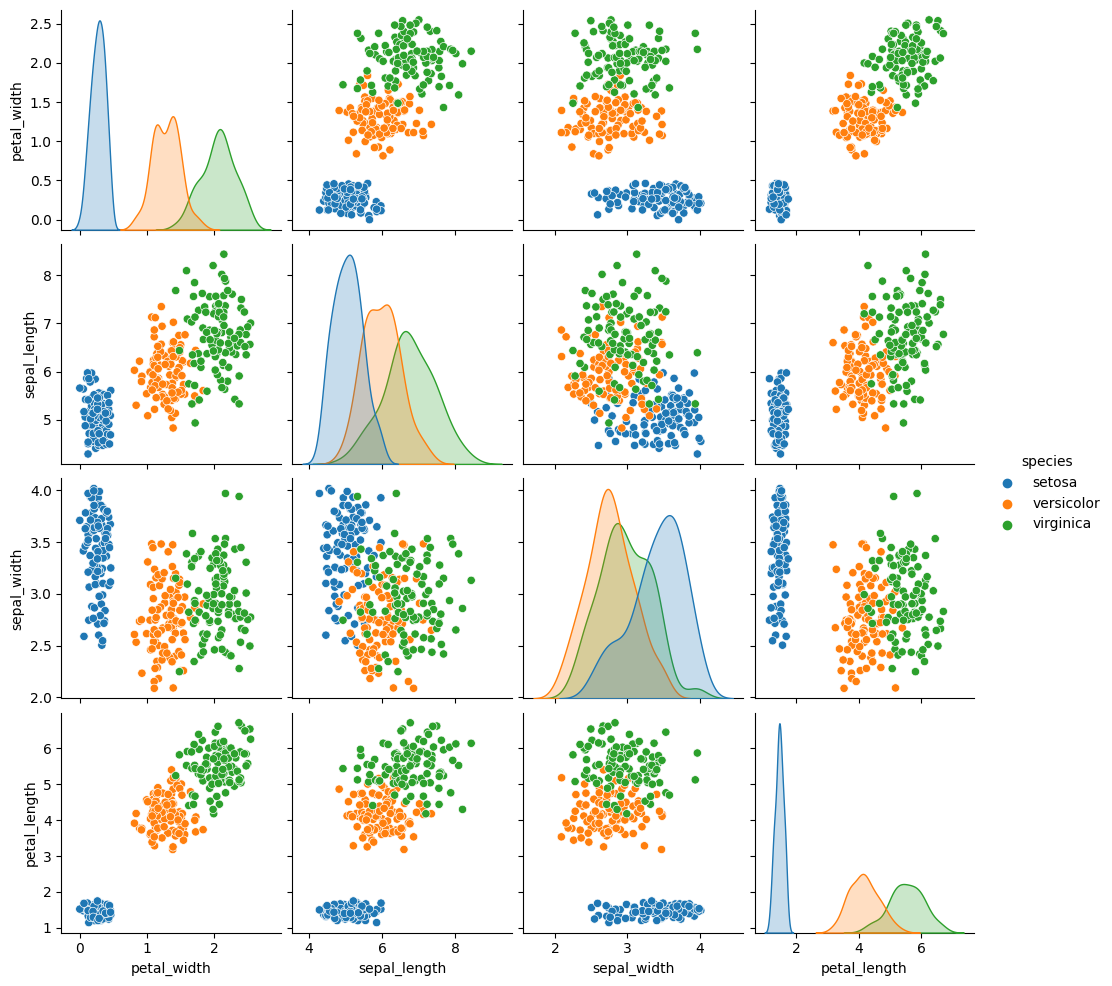

In [13]:
sns.pairplot(data =gnb_df, hue='species')

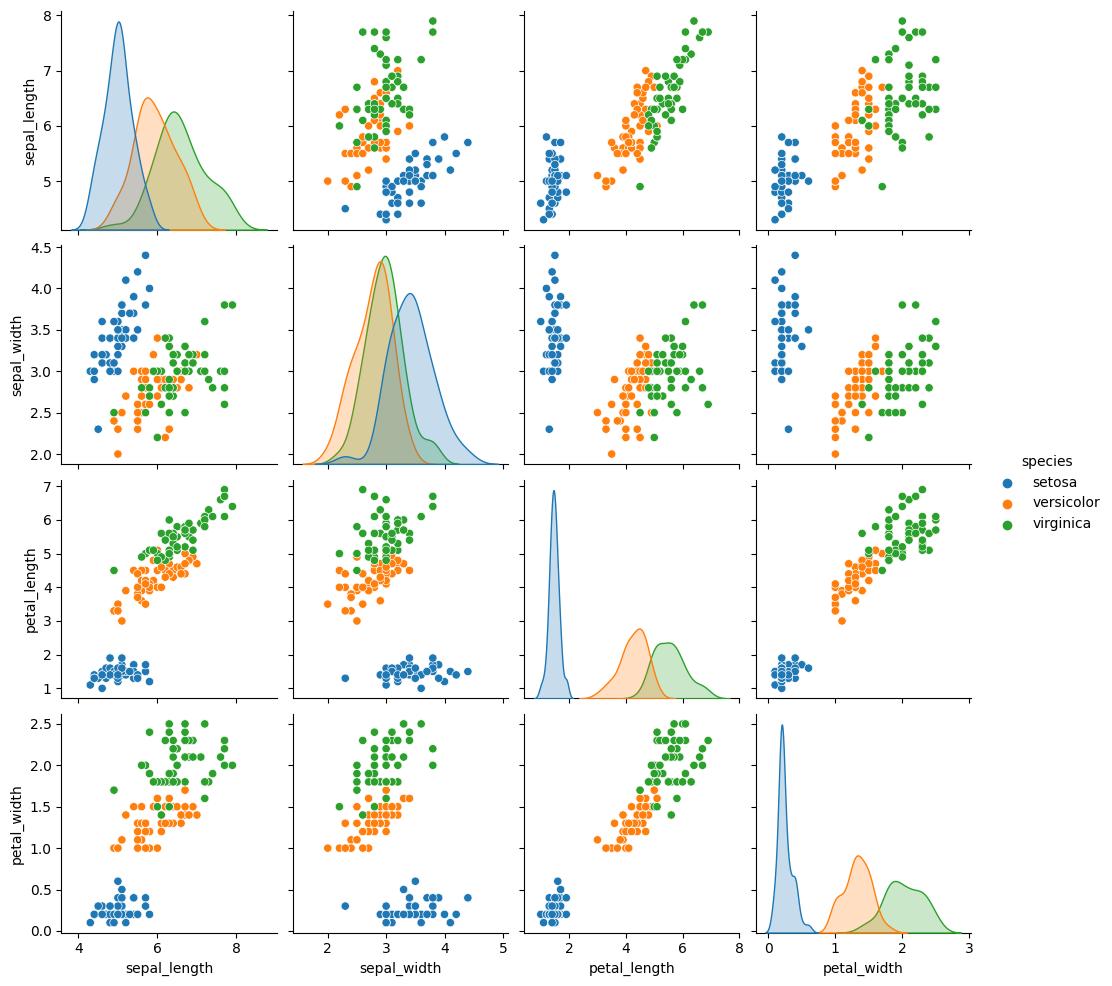

In [14]:
sns.pairplot(data=iris_df,hue='species')

In [15]:
y_pred = gnb.predict(X_test)

In [16]:
sum(y_pred ==y_test)/len(y_test)

1.0

In [17]:
gnb.score(X_test,y_test)

1.0

In [18]:
metrics.confusion_matrix(y_test,y_pred)

array([[13,  0,  0],
       [ 0, 16,  0],
       [ 0,  0,  9]])